# MyMDB Analyzer
This notebook accesses the IMDb-Scraping pipeline consisting of the webscraper, the database connector and provides a GUI for the interactive visualization.

![IMDb Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/440px-IMDB_Logo_2016.svg.png)

[Wikipedia IMDb Definition](https://en.wikipedia.org/wiki/IMDb):

IMDb (an acronym for `I`nternet `M`ovie `D`ata`b`ase) is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online – including cast, production crew and personal biographies [...]

This notebook visually explores rankings of movies and actors and 

## USAGE
Step through this notebook manually so everything is executed in order

#### OVERCOMING TECHNICAL DIFFICULTIES

In [1]:
# workarround for using event_loops in notebooks (ipykernel already uses the global non-reentrant one)
import nest_asyncio
nest_asyncio.apply()

#### Imports

In [2]:
import db
import analyze
import ui

connecting to db via conn_str: DRIVER=SQL Server;SERVER=localhost;PORT=1433;DATABASE=MyMDB;UID=SA;PWD=Pr0dRdyPw!


### SCRAPING
Challenges were respecting the site's scraping rules located in robots.txt, not getting timed out even though we followed through and handling those timeouts as well as handling (rather omitting a ton of) missing/format-inhomogenous data as well as asynchronous caching in python.

In [3]:
movies = []
import_ui = ui.init_ui(movies)
import_ui

50 movies acquired

In [5]:
movies = import_ui.movies
# try:
#     movies = import_ui.movies
# except AttributeError:
#     input("press enter to continue")
#     movies = import_ui.movies

### INSERTION
This part was done purely in the SQL Server Backend, using a stored procedure for parsing the insertion data, and taking care of NaN values and the likes.

A trigger was used to recursively update the average instead of recomputation over several tables for each new insert.

In [6]:
for movie in movies:
    try:
        db.insert_movie(**movie)
    except Exception as e:
        print(f"issue at {movie}\n{e}")
"no duplicates found" if db.check_no_duplicates() else "duplicates in actors detected"

'no duplicates found'

### READING
For further analysis the movies are queried back from the db and converted to dataframes

In [7]:
df_movies = analyze.get_movie_dataframe()
df_actors = analyze.get_actors_dataframe()
df_movie_actors = analyze.get_movie_actors_dataframe()
df_actor_features = analyze.get_actor_feature_dataframe()
df_summary = (
 analyze.get_summary_dataframe()
 .sort_values(by="name")
)

display("movies", df_movies.head())
display("actors", df_actors.head())
display("movie_actors", df_movie_actors.head(5))
display("joined data", df_summary.head(10))
display(
    df_summary
    .drop(["movie_id", "actor_id"], axis=1)
    .describe()
)
display("interesting features for actor analysis", df_actor_features.head())
display(df_actor_features.describe())

'movies'

,id,title,year,genre,rating,budget,gross_income
0,271,Spiel mir das Lied vom Tod,1968,Western,8.4,5000000.0000,5435024.0000
1,272,Schindlers Liste,1993,Biografie,8.9,22000000.0000,322161245.0000
2,275,Der Soldat James Ryan,1998,Drama,8.6,70000000.0000,482349603.0000
3,276,Moderne Zeiten,1936,Komödie,8.4,1500000.0000,463618.0000
4,277,Zurück in die Zukunft,1985,Abenteuer,8.5,19000000.0000,383336762.0000


'actors'

,id,name,age,avg_rating
0,1280,Charles Bronson,101,8.4
1,1281,Frank Braña,89,8.4
2,1282,Livio Andronico,-1,8.4
3,1283,Marilù Carteny,-1,8.4
4,1284,Paolo Stoppa,117,8.4


'movie_actors'

,movie_id,actor_id
0,271,1280
1,271,1281
2,271,1282
3,271,1283
4,271,1284


'joined data'

,name,age,avg_rating,movie_id,actor_id,title,year,genre,rating,budget,gross_income
90,Abdullah Abbas,116,8.5,292,1434,Casablanca,1942,Drama,8.5,950000.0000,4627326.0000
146,Abe Vigoda,102,9.2,305,1517,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
16,Adam Goldberg,52,8.6,275,1315,Der Soldat James Ryan,1998,Drama,8.6,70000000.0000,482349603.0000
10,Adi Nitzan,-1,8.9,272,1291,Schindlers Liste,1993,Biografie,8.9,22000000.0000,322161245.0000
118,Alan Howard,85,8.8,316,1585,Der Herr der Ringe: Die Gefährten,2001,Action,8.8,93000000.0000,898204420.0000
188,Alec Guinness,-1,8.7,320,1607,Das Imperium schlägt zurück,1980,Action,8.7,18000000.0000,538375067.0000
172,Alexandre Rodrigues,-1,8.6,311,1556,City of God,2002,Krimi,8.6,3300000.0000,30680793.0000
106,Ali Astin,26,8.9,297,1470,Der Herr der Ringe: Die Rückkehr des Königs,2003,Action,8.9,94000000.0000,1147633833.0000
171,Alice Braga,-1,8.6,311,1555,City of God,2002,Krimi,8.6,3300000.0000,30680793.0000
139,Amandla Stenberg,24,8.8,303,1505,Spider-Man: Across the Spider-Verse,2023,Animation,8.8,150000000.0000,559954279.0000


,age,avg_rating,year
count,196.000000,196.000000,196.000000
mean,49.903061,8.638776,1988.586735
std,45.625294,0.204128,20.930107
min,-1.000000,8.400000,1936.000000
25%,-1.000000,8.500000,1980.000000
50%,57.000000,8.600000,1994.000000
75%,79.500000,8.800000,2002.000000
max,148.000000,9.200000,2023.000000


'interesting features for actor analysis'

,name,age,appearances,avg_rating
0,Sterling Hayden,107,1,9.2
1,Neil Giuntoli,63,1,9.2
2,Morgana King,93,1,9.2
3,Lenny Montana,97,1,9.2
4,Jude Ciccolella,76,1,9.2


,age,appearances,avg_rating
count,118.000000,118.000000,118.000000
mean,80.050847,1.042373,8.634746
std,29.654664,0.240870,0.217357
min,24.000000,1.000000,8.400000
25%,58.000000,1.000000,8.500000
50%,75.000000,1.000000,8.500000
75%,101.000000,1.000000,8.800000
max,148.000000,3.000000,9.200000


### Visualization


c:\Users\NiJoL\anaconda3\envs\MyMDB\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


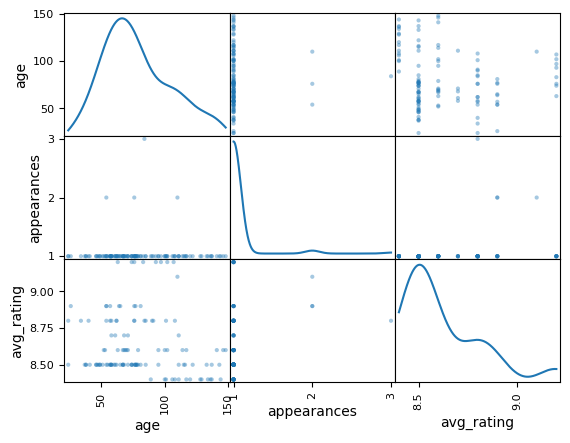

In [8]:
analyze.scattermatrix_actors(
    df_actor_features.drop(df_actor_features[df_actor_features["age"] == -1].index)
)

# outlook

- scrape random movies and try to classify if a given actor could really make it using the top 250 (interesting outliers for certain actors included in top 250 that say only did a single movie)
- try to predict imdb rating